Testing blip finetuned model:

In [30]:
from transformers import BlipForConditionalGeneration, AutoProcessor

device = "cuda"
model = BlipForConditionalGeneration.from_pretrained("/kaggle/input/blip-image-captioning-base-rscid-finetuned/transformers/5_epochs/1").to(device)
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

In [12]:
from datasets import load_dataset

dataset = load_dataset("arampacha/rsicd", split="test")

In [13]:
print(dataset)

Dataset({
    features: ['filename', 'captions', 'image'],
    num_rows: 1093
})


a playground is surrounded by many green trees and several buildings.


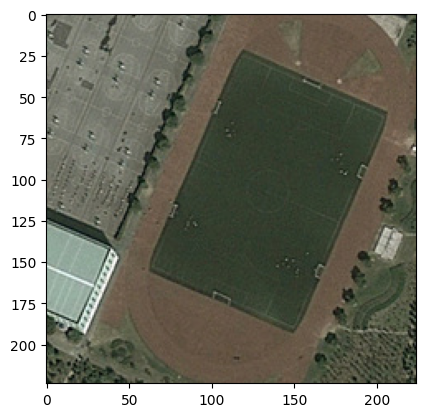

In [31]:
from matplotlib import pyplot as plt
# print()
image = dataset[641]["image"]
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)
plt.imshow(image)

In [3]:
from matplotlib import pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

res = []
for i, example in enumerate(dataset):
    reference = [ caption.split() for caption in example["captions"] ] 
    image = example["image"]
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=64)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
#     print(generated_caption)
    res.append(sentence_bleu(reference, generated_caption.split()))

print(sum(res) / len(res))

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.5625453118858312


Testing clip finetuned model:

In [23]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/clip-gpt2-rsicd-finetuned-5-epochs/image-captioning-output/checkpoint-2730").to("cuda")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

a playground with a football field in it is surrounded by many green trees and several buildings.


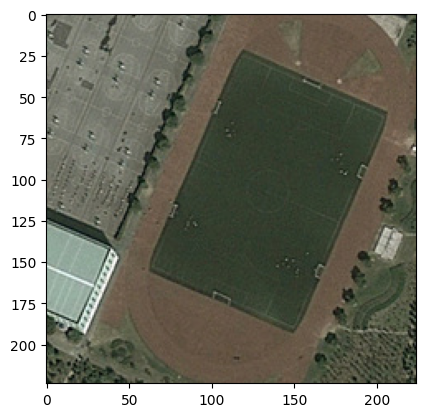

In [29]:
from matplotlib import pyplot as plt
# print()
max_length = 64
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
image = dataset[641]["image"]
pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values
pixel_values = pixel_values.to("cuda")

output_ids = model.generate(pixel_values, **gen_kwargs)

preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
preds = [pred.strip() for pred in preds][0]
print(preds)
plt.imshow(image)

In [5]:
from matplotlib import pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

res = []
max_length = 64
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
for i, example in enumerate(dataset):
    reference = [ caption.split() for caption in example["captions"] ] 
    image = example["image"]
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to("cuda")

    output_ids = model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds][0]
    res.append(sentence_bleu(reference, preds.split()))

print(sum(res) / len(res))

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


0.580789020838985
